In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('clean_data.csv')

C:\Users\vtodd\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
y = df.price

#only taking values, where we don't have a zero count across all observations
X = df.drop(columns = ['price', 'id', 'name', 'release_date']).loc[:, (df != 0).any(axis=0)]


In [4]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
X['developer'] = LE.fit_transform(X['developer'])
X.age = X.age.astype('str').str.rstrip('+').astype(int)

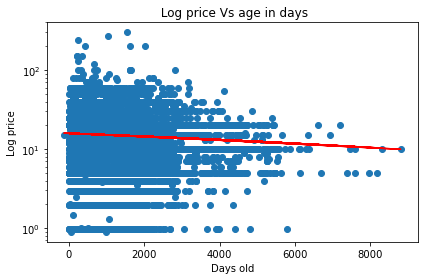

In [5]:
fig = plt.figure()
plt.yscale('log')
plt.title(' Log price Vs age in days')
plt.xlabel('Days old')
plt.ylabel('Log price')
plt.scatter(X['time_delta'], y)
m, b = np.polyfit(X['time_delta'], y, 1)
plt.plot(X['time_delta'], m*X['time_delta'] + b, color = 'red')
fig.tight_layout()

In [6]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.model_selection import train_test_split

In [7]:
X_dev, X_test, y_dev, y_test = train_test_split(X.values, y.values, test_size = 2/10, random_state = 1337)

In [8]:
X_scaled = StandardScaler().fit_transform(X_dev)

In [9]:
X_scaled.shape

(7989, 453)

In [10]:
from sklearn.decomposition import PCA

pcamodel = PCA(n_components = 453)
pcamodel.fit(X_scaled)

PCA(n_components=453)

In [11]:
for i in range(453):
    if sum(pcamodel.explained_variance_ratio_[0:i]) >= 0.90:
        print(i)
        break

333


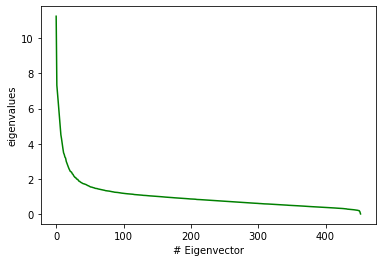

In [12]:
eigenvalues = pcamodel.explained_variance_ratio_
fig1, ax1 = plt.subplots()
ax1.plot(eigenvalues, color = 'green')
#ax1.set_yscale('log')
ax1.set(xlabel = '# Eigenvector', ylabel = 'eigenvalues')
plt.show()

In [13]:
pcamodel.set_params(n_components = 333)
X_pca = pcamodel.fit_transform(X_scaled)

In [14]:
# First we perform parameter tuning on the lambda of the lasso model
# The first search was done in the space np.logspace(-4, 4, 12)
# Here we found that a lambda of 0.83... was the best, so we narrow the space down in a grid search further below

In [15]:
from sklearn.model_selection import KFold
lambdas =  np.logspace(-4, 4, 12)
kfolds = KFold(n_splits=10)
folds = list(kfolds.split(X_dev, y_dev))
MSE_lambda_lasso = []
for lambda_ in lambdas:
    MSE_cv = []
    for train_idx, val_idx in folds:
        
        pipe_Lasso = make_pipeline(StandardScaler(),\
                                   PCA(n_components = 333),\
                                   #PolynomialFeatures(degree = 2, include_bias = False),\
                                   Lasso(alpha = lambda_, random_state = 1337))
        X_train, y_train = X_dev[train_idx], y_dev[train_idx]
        X_val, y_val = X_dev[val_idx], y_dev[val_idx]
        pipe_Lasso.fit(X_train, y_train)
        MSE_cv.append(mse(pipe_Lasso.predict(X_val), y_val))
        
    MSE_lambda_lasso.append(np.mean(MSE_cv))

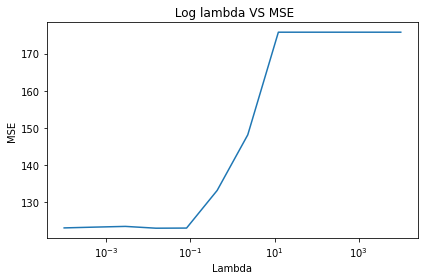

In [16]:
lambdaCV_lasso = pd.Series(MSE_lambda_lasso, index=lambdas)
fig = plt.figure()
plt.xscale('log')
plt.title(' Log lambda VS MSE')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.plot(lambdaCV_lasso)
fig.tight_layout()

In [17]:
lambdaCV_lasso.nsmallest(1)

0.015199    123.077193
dtype: float64

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

lambdas =  np.logspace(-3, 0, 12)
pipe_ElasticNet = make_pipeline(StandardScaler(),
                                PCA(n_components = 333),
                                #PolynomialFeatures(degree = 2, include_bias = False),
                                ElasticNet(random_state = 1337))

gs_ElasticNet = GridSearchCV(estimator=pipe_ElasticNet,
                             param_grid={'elasticnet__alpha':lambdas,
                                         'elasticnet__l1_ratio': np.linspace(0,1,20)},
                             scoring='neg_mean_squared_error',
                             n_jobs=4,
                             cv=10)

In [ ]:
gs_ElasticNet.fit(X_dev, y_dev)
gsPCA.best_params_

In [ ]:
print(mse(gs_ElasticNet.predict(X_dev), y_dev))
print(mse(gs_ElasticNet.predict(X_test), y_test))